In [1]:
#importing all the libraries
import os
import csv
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
samples = []
batch_size = 64
correction = 0.2 # this is a parameter to tune

with open('challenge_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

In [4]:
def generator(samples, batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                #for center image
                name_c = 'challenge_data/IMG/'+ batch_sample[0].split('\\')[-1]
                center_image = mpimg.imread(name_c)
                center_angle = float(batch_sample[3])             
                images.append(center_image)
                angles.append(center_angle)
                
                #for left image
                name_l = 'challenge_data/IMG/'+ batch_sample[1].split('\\')[-1]
                left_image = mpimg.imread(name_l)
                images.append(left_image)
                left_angle = center_angle + correction
                angles.append(left_angle)
                
                #for right image
                name_r = 'challenge_data/IMG/'+ batch_sample[2].split('\\')[-1]
                right_image = mpimg.imread(name_r)
                images.append(right_image)
                right_angle = center_angle - correction
                angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [5]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [6]:
model = Sequential()

model.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(32, (5,5), strides=2, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (5,5), strides=2, activation='relu'))
model.add(MaxPooling2D()) 

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu')) 
model.add(Dense(1))

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 32)       2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 38, 32)         25632     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [7]:
checkpoint = ModelCheckpoint("model1.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss='mse', optimizer='adam')
hh = model.fit_generator(train_generator, steps_per_epoch=np.ceil(len(train_samples)/batch_size),
                    validation_data=validation_generator,validation_steps=np.ceil(len(validation_samples)/batch_size),
                    callbacks=callbacks, epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
57/57 [==============================] - 31s 539ms/step - loss: 0.1420 - val_loss: 0.1151

Epoch 00001: val_loss improved from inf to 0.11514, saving model to model/model1.h5
Epoch 2/10
57/57 [==============================] - 18s 320ms/step - loss: 0.1189 - val_loss: 0.1076

Epoch 00002: val_loss improved from 0.11514 to 0.10762, saving model to model/model1.h5
Epoch 3/10
57/57 [==============================] - 19s 332ms/step - loss: 0.1147 - val_loss: 0.1059

Epoch 00003: val_loss improved from 0.10762 to 0.10592, saving model to model/model1.h5
Epoch 4/10
57/57 [==============================] - 19s 334ms/step - loss: 0.1094 - val_loss: 0.1059

Epoch 00004: val_loss improved from 0.10592 to 0.10591, saving model to model/model1.h5
Epoch 5/10
57/57 [==============================] - 19s 333ms/step - loss: 0.1067 - val_loss: 0.1031

Epoch 00005: val_loss improved from 0.10591 to 0.10313, saving model to model/model1.h5
Epoch 

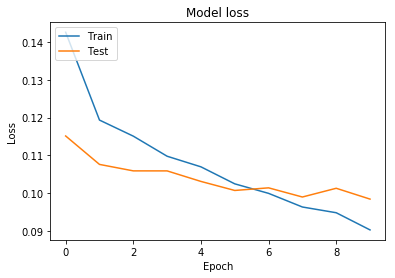

In [8]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(hh.history['loss'])
plt.plot(hh.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()